# Image classification with TensorFlow 

Based on an original notebook by the TensorFlow authors, licensed under Apache 2.0.

**Note: You need to sign in to Google to run this notebook.**

Use **Shift + Enter** to run the cells. When prompted, click **Run anyway** then **Yes**. Try it on this cell...

In [19]:
import os

if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; change the runtime type!')
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

TPU address is grpc://10.103.148.234:8470


## Overview

In this notebook, we're going to classify some images of fossils... in fewer than 80 lines of code.

A 'notebook' is an interactive coding and note-taking environment. We're going to be using some cutting edge technology, right in your browser. We will see:

- A deep neural network in action.
- Google's TensorFlow deep learning library.
- Google's 'tensor processing unit' (TPU) deep learning hardware acceleration.
- All of this is running on Google's cloud infrastructure, for free.

There are fewer than 80 lines of code altogether.

## Load the data

We'll begin by downloading the dataset. Run this cell:

In [12]:
import requests
import numpy as np
from io import BytesIO

X_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/image_X.npy")
y_ = requests.get("https://s3.amazonaws.com/agilegeo/geocomp/integer_y.npy")

X = np.load(BytesIO(X_.content))
y = np.load(BytesIO(y_.content))

print("Data loaded!")

Data loaded!


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.316)

X_train.shape

(400, 32, 32, 1)

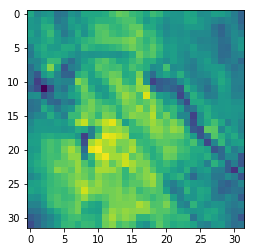

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(X_train[0, :, :, 0])

In [16]:
y_train

array([1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0,
       2, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 2, 1, 0, 2, 0,
       2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2,
       1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1,
       0, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 2, 0,
       2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0,
       2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2,
       1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2,
       0, 1, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 1, 2,
       0, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1,
       2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0,
       1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0,
       0, 2, 2, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 0, 0,

## Shallow learning model

In [5]:
X_train.shape, X_val.shape

((400, 32, 32, 1), (186, 32, 32, 1))

In [0]:
from sklearn.svm import SVC



Evaluating the model, we see that we got about 60% accuracy:

## Deep learning model

The following example uses a standard conv-net that has 3 layers with drop-out and batch normalization between each layer.

In [0]:
import tensorflow as tf

def create_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(3))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

## Train on the TPU

To begin training, construct the model on the TPU and then compile it.

The following code demonstrates the use of a generator function and `fit_generator` to train the model.  Alternately, you can pass in `x_train` and `y_train` to `tpu_model.fit()`.

In [20]:
from contextlib import contextmanager


try:
    resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.contrib.distribute.initialize_tpu_system(resolver)
    strategy = tf.contrib.distribute.TPUStrategy(resolver)
except:
    strategy = None

none_context = contextmanager(lambda: iter([None]))()

with (strategy.scope() if strategy else none_context):
    model = create_model(input_shape=X_train.shape[1:])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

INFO:tensorflow:Initializing the TPU system: 10.103.148.234:8470


INFO:tensorflow:Initializing the TPU system: 10.103.148.234:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Querying Tensorflow master (grpc://10.103.148.234:8470) for TPU system metadata.


INFO:tensorflow:Querying Tensorflow master (grpc://10.103.148.234:8470) for TPU system metadata.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6632707102883938449)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6632707102883938449)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7186737417859783639)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7186737417859783639)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2922544448792854227)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2922544448792854227)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5742104487904605038)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5742104487904605038)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16229129824289296191)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16229129824289296191)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13307771088482023223)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 13307771088482023223)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14510359751342365290)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 14510359751342365290)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 10548231219937813425)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 10548231219937813425)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8438314197791549924)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 17179869184, 8438314197791549924)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 13771323888256622214)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, 13771323888256622214)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6674462929309764834)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6674462929309764834)


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        51232     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)         

In [22]:
model.fit(
    X_train.astype(np.float32),
    y_train.astype(np.float32),
    epochs=32,
    steps_per_epoch=50,
    validation_data=(X_val.astype(np.float32), y_val.astype(np.float32)),
    validation_freq=32
)

model.save_weights('./fossils.h5', overwrite=True)

Epoch 1/32
50/50 [==============================] - 2s 47ms/step - loss: 1.7832 - sparse_categorical_accuracy: 0.4300
Epoch 2/32
50/50 [==============================] - 1s 14ms/step - loss: 1.0919 - sparse_categorical_accuracy: 0.5025
Epoch 3/32
50/50 [==============================] - 1s 14ms/step - loss: 1.0005 - sparse_categorical_accuracy: 0.5175
Epoch 4/32
50/50 [==============================] - 1s 13ms/step - loss: 0.9970 - sparse_categorical_accuracy: 0.5600
Epoch 5/32
50/50 [==============================] - 1s 14ms/step - loss: 1.0075 - sparse_categorical_accuracy: 0.5050
Epoch 6/32
50/50 [==============================] - 1s 13ms/step - loss: 0.8801 - sparse_categorical_accuracy: 0.5850
Epoch 7/32
50/50 [==============================] - 1s 14ms/step - loss: 0.8709 - sparse_categorical_accuracy: 0.6050
Epoch 8/32
50/50 [==============================] - 1s 14ms/step - loss: 0.8104 - sparse_categorical_accuracy: 0.6600
Epoch 9/32
50/50 [==============================] - 1s 1

INFO:tensorflow:Running validation at fit epoch: 31


50/50 [==============================] - 5s 107ms/step - loss: 0.2643 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.8159 - val_sparse_categorical_accuracy: 0.6828


## Check the results (inference)

Now that you are done training, see how well the model can predict fossil types.

In [0]:
LABEL_NAMES = ['ammonites', 'fish', 'trilobites']

cpu_model = create_model(X_train.shape[1:])
cpu_model.load_weights('./fossils.h5')

y_pred = cpu_model.predict(X_val)

In [0]:
import random

def visualize(X_val, y_val, y_prob, cutoff=0.5, ncols=6, nrows=3, figsize=(12, 8), classes=None, shape=None):
    """
    Visualize some random samples from the prediction results.
    Colours: green for a good prediction, red for a wrong one. If the
    probability was less than some cutoff (default 0.5), we'll mute the colour.

    Args:
        X_val (ndarray): The validation features, n_samples x n_features.
        y_val (ndarray): The validation labels, n_samples x 1.
        y_prob (ndarray): The predicted probabilities, n_samples x n_classes.
        cutoff (float): the cutoff for 'uncertain'.
        ncols (int): how many plots across the grid.
        nrows (int): how many plots down the grid.
        figsize (tuple): tuple of ints.
        classes (array-like): the classes, in order. Will be inferred if None.
        shape (tuple): Shape of each instance, if it needs reshaping.
    """
    idx = random.sample(range(X_val.shape[0]), ncols*nrows)
    sample = X_val[idx]

    if classes is None:
        classes = np.unique(y_val)
    else:
        y_val = np.asarray(classes)[y_val]

    fig, axs = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows)
    axs = axs.ravel()

    for ax, img, actual, probs in zip(axs, sample, y_val[idx], y_prob[idx]):

        pred = classes[np.argmax(probs)]
        prob = np.max(probs)
        if shape is not None:
            img = img.reshape(shape)

        ax.imshow(np.squeeze(img), cmap='gray')
        ax.set_title(f"{pred} - {prob:.3f}\n[{actual}]")
        ax.set_xticks([])
        ax.set_yticks([])

        if prob > cutoff:
            c = 'limegreen' if (actual == pred) else 'red'
        else:
            c = 'y' if (actual == pred) else 'lightsalmon'

        for spine in ax.spines.values():
            spine.set_edgecolor(c)
            spine.set_linewidth(4)

    return

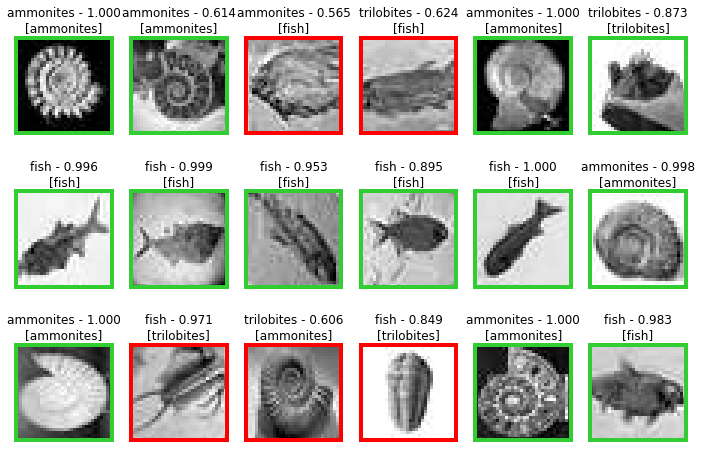

In [58]:
visualize(X_val, y_val, y_pred, classes=LABEL_NAMES)

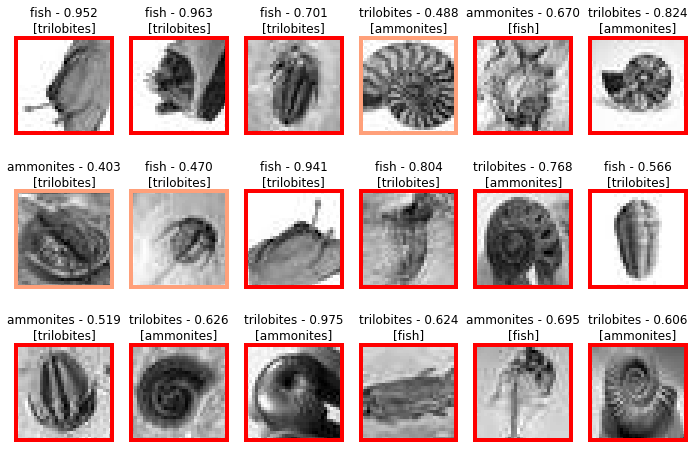

In [65]:
# Incorrectly classified only.
wrong_idx = np.argmax(y_pred, axis=-1) != y_val
y_pred_ = y_pred[wrong_idx]
y_val_ = y_val[wrong_idx]
X_val_ = X_val[wrong_idx]

visualize(X_val_, y_val_, y_pred_, classes=LABEL_NAMES)